In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skfeature.function.similarity_based import fisher_score, lap_score
from skfeature.utility import construct_W

from sklearn.manifold import MDS, TSNE
from sklearn.preprocessing import StandardScaler


from lib.help_function import *
from lib.rank_lib import *
from lib.feature_lib import *

In [4]:
DATA_PATH_2 = './data/LSVT_voice_rehabilitation.xlsx'

#LSTV voice rehabilitation

data = pd.read_excel(DATA_PATH_2,'Data')
#data =np.array(data)
#data.head(3)

label = pd.read_excel(DATA_PATH_2,'Binary response')
#label = np.array(label)
#label = label.replace(1,0)
#label = label.replace(2,1)
#label.head(3)

In [5]:
data_label = label
data = data
data_normalize = (data- data.mean()) / (data.std())
print(np.shape(label))

label = np.squeeze(label, axis =1)
print(np.shape(label))

#print(np.shape(temp))
#temp
col_name_list = data_normalize.columns
#data_normalize.head()

(126, 1)
(126,)


In [6]:
min_max_scaler = preprocessing.MinMaxScaler()
min_max_data = min_max_scaler.fit_transform(data_normalize)
data_normal_scale = pd.DataFrame(min_max_data)

data_normal_scale.columns = col_name_list
data_normal_scale.head()

temp_data_scale = min_max_scaler.fit_transform(data)
temp_data_scale = pd.DataFrame(min_max_data)
temp_data_scale.columns = col_name_list
temp_data_scale.head()


,Jitter->F0_abs_dif,Jitter->F0_dif_percent,Jitter->F0_PQ5_classical_Schoentgen,Jitter->F0_PQ5_classical_Baken,Jitter->F0_PQ5_generalised_Schoentgen,Jitter->F0_abs0th_perturb,Jitter->F0_CV,Jitter->F0_TKEO_mean,Jitter->F0_TKEO_std,Jitter->F0_TKEO_prc5,...,det_TKEO_std4_1_coef,det_TKEO_std4_2_coef,det_TKEO_std4_3_coef,det_TKEO_std4_4_coef,det_TKEO_std4_5_coef,det_TKEO_std4_6_coef,det_TKEO_std4_7_coef,det_TKEO_std4_8_coef,det_TKEO_std4_9_coef,det_TKEO_std4_10_coef
0,0.033021,0.030309,0.029885,0.366089,0.034824,0.008753,0.000071,0.037740,0.091154,0.989590,...,0.449996,0.445992,0.446291,0.447718,0.443378,0.448639,0.447248,0.446953,0.464189,0.472513
1,0.068977,0.047349,0.048153,0.427701,0.014028,0.009366,0.000082,0.089853,0.192283,0.963673,...,0.635807,0.634083,0.633573,0.634728,0.633459,0.635146,0.636258,0.636462,0.648218,0.652997
2,0.260608,0.684206,0.688881,0.386061,0.619113,0.055664,0.088027,0.044422,0.016357,0.928397,...,0.023461,0.020355,0.016936,0.006940,0.000000,0.000000,0.000000,0.000000,0.031096,0.040043
3,0.005195,0.014441,0.014471,0.389567,0.015053,0.000941,0.000014,0.000743,0.012245,0.999033,...,0.137878,0.132955,0.130841,0.127759,0.121730,0.128634,0.129459,0.129326,0.155887,0.168257
4,0.027197,0.027453,0.013318,0.574226,0.100303,0.003306,0.006224,0.048214,0.111263,0.995374,...,0.405954,0.406447,0.397706,0.402240,0.396841,0.401573,0.401064,0.400494,0.419376,0.427514


In [7]:
def tdaSelection(data,lens,r,is_min_best=True,equalize=True):
    '''
    r 값 (cluster 갯수)
        
    cluster마다 feature를 몇개 뽑을것인지
    
    최적 cluster + 최적 feature
    
    '''
    
    
    data_scaled = StandardScaler().fit_transform(data)
    clusters = {}
    
    if equalize==True:
        score_ = score.sort_values()
        m = len(data.T)
        k = int(m/r)
        for i in np.arange(r):
            clusters[i] = list(score_.sort_values()[i*k:(i+1)*k].index)
        clusters[r-1] += list(score_.sort_values()[r*k:].index)
    else:
        bins = np.histogram(lens,bins=r)[1]
        bins[-1] = np.inf
        for i,f in zip(np.digitize(lens,bins),lens.index):
            if (i-1 not in clusters.keys()):
                clusters[i-1] = [f]
            else:
                clusters[i-1].append(f)
                
    dist = pd.DataFrame(np.arccos(abs(np.corrcoef(data_scaled.T))),index=data.columns,columns=data.columns)
    distmat = pd.DataFrame(np.zeros((len(clusters.keys()),len(clusters.keys()))),index=clusters.keys(),columns=clusters.keys())
    for i in np.arange(len(distmat)):
        for j in np.arange(i):
            distmat.iloc[i,j] = dist.loc[clusters[distmat.index[i]],clusters[distmat.index[j]]].min().min()
    distmat += distmat.T
            
    initial_cluster = max(clusters.keys()) if (is_min_best==True) else 0
    initial_feature = lens[clusters[initial_cluster]].idxmin() if (is_min_best==True) else lens[clusters[initial_cluster]].idxmax()
    
    used_clusters = [initial_cluster]
    selected_features = [initial_feature]
    
    for k in clusters.keys():
        if k==initial_cluster:
            continue
        else:
            new_cluster = distmat[used_clusters].min(axis=1).idxmax()
        used_clusters += [new_cluster]
        new_feature = lens[clusters[new_cluster]].idxmin() if (is_min_best==True) else lens[clusters[new_cluster]].idxmax()
        selected_features.append(new_feature)
        
    return selected_features,clusters,used_clusters

In [225]:
rawdata = pd.read_csv('./data/parkinson_disease_speech.csv',header=1)
rawdata.head()

label = rawdata['class']


In [226]:
data = rawdata.iloc[:,2:-1]
data.head()

,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,...,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36
0,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,0.000018,0.00067,...,1.5466,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405
1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,0.000016,0.00052,...,1.5530,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780
2,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,0.000015,0.00057,...,1.5399,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666
3,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,0.000046,0.00149,...,6.9761,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603
4,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,0.000044,0.00166,...,7.8832,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164


In [8]:
data_scaled = StandardScaler().fit_transform(data)

In [10]:
kwargs_W = {'metric':'euclidean','neighbor_mod':'knn','weight_mode':'heat_kernel','k':5,'t':1}
W = construct_W.construct_W(data_scaled,**kwargs_W)
score = pd.Series(fisher_score.fisher_score(data.values, label),index=data.columns)

print(score)

Jitter->F0_abs_dif                          1.075227e-01
Jitter->F0_dif_percent                      9.686117e-02
Jitter->F0_PQ5_classical_Schoentgen         9.830629e-02
Jitter->F0_PQ5_classical_Baken              1.049863e-07
Jitter->F0_PQ5_generalised_Schoentgen       5.530888e-02
Jitter->F0_abs0th_perturb                   2.529665e-02
Jitter->F0_CV                               1.683832e-02
Jitter->F0_TKEO_mean                        5.987862e-02
Jitter->F0_TKEO_std                         4.255537e-02
Jitter->F0_TKEO_prc5                        6.348647e-02
Jitter->F0_TKEO_prc25                       4.231842e-02
Jitter->F0_TKEO_prc75                       5.896459e-03
Jitter->F0_TKEO_prc95                       3.977910e-02
Jitter->F0_FM                               7.110201e-02
Jitter->F0range_5_95_perc                   3.079737e-02
Jitter->pitch_abs                           6.830054e-02
Jitter->pitch_percent                       1.078560e-01
Jitter->pitch_PQ5_classical_Sch

In [12]:
#print(len(rawdata))
print(len(label))
#print(type(rawdata))

temp, rank = get_fisher_score(data.values,label)

126


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [33]:
selected_features, clusters, used_clusters = tdaSelection(data,score,30,is_min_best = False,equalize=False)

In [34]:
type(selected_features)
selected_features = selected_features[1:]
print(len(selected_features))

print(selected_features)

21
['VFER->SNR_SEO', 'IMF->SNR_TKEO', 'MFCC_2nd coef', 'HNR->HNR_dB_Praat_std', 'MFCC_1st coef', 'entropy_log_1_coef', 'DFA', 'Log energy', 'IMF->NSR_SEO', 'NHR->NHR_Praat_std', 'entropy_log_6_coef', 'entropy_log_10_coef', 'entropy_log3_5_coef', 'IMF->SNR_entropy', 'entropy_log_2_coef', 'Shimmer->Ampl_AM', 'Jitter->F0_TKEO_prc5', 'Jitter->F0_PQ5_classical_Schoentgen', 'IMF->NSR_entropy', '12th delta-delta', 'entropy_shannon2_2_coef']


In [35]:
#selected_features[0:2]
#selected_features[0:99]


In [36]:
import numpy as np
import pandas as pd
import random

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

In [37]:
def init_model_list():
    '''
    No Input
    
    Output : model list
    '''
    models = []
    
    models.append(('LR', LogisticRegression(solver='lbfgs')))
    models.append(('RF', RandomForestClassifier()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('SVM', SVC(gamma='auto')))
    models.append(('LSVM', LinearSVC()))
    models.append(('GNB', GaussianNB()))
    models.append(('DTC', DecisionTreeClassifier()))
    models.append(('GBC', GradientBoostingClassifier()))
    models.append(('XG', XGBClassifier()))
    
    acc_lists = [[] for i in range(len(models))]
    
    return models,acc_lists

In [38]:

def feature_tda_test(data, label, features_list):
    '''
    Find optimized featrue
    Input
        data 
        label
    Output
        1. optimized feature number
        2. Optimized feature plot
    
    '''
    model_list,acc_list = init_model_list()
 
    for i in range(len(features_list)):
        #print(i)
        select_feature_list = features_list[0:i+1]
        x_selected = data[select_feature_list]
        
        print('length of features : ', len(select_feature_list))
        x_train, x_test, y_train, y_test = train_test_split(x_selected,label, test_size=0.2, random_state=42)
        idx = 0
        
        for name, model in model_list:
            model.fit(x_train, y_train)
            model_acc = accuracy_score(y_test, model.predict(x_test))
            acc_list[idx].append(model_acc)
            
            idx = idx+1
            
    return model_list,acc_list

def plot_tda_model_acc(model_list,model_mean_acc_list,
                          file_name ='tda_output',save_folder = 'result',fig_size = (12,12)):
    
    if os.path.isdir('./'+save_folder) == False:
        os.mkdir('./'+save_folder)
    else:
        print('already exist the folder in this path : {}'.format('./'+save_folder))
        
    f1 = plt.figure(figsize=fig_size)
    plt.xlabel('number of features')
    plt.ylabel('acc')
    
    idx = 0
    for name,_ in model_list:
        #print(name)
        plt.plot(range(len(model_mean_acc_list[0,:])), list(model_mean_acc_list[idx,:]),label = name)        
        idx = idx+1
          
    plt.legend()
    
    f1.savefig(save_folder + '/'+file_name+'.png')
    
    f2 = plt.figure(figsize=fig_size)
    plt.xlabel('number of features')
    plt.ylabel('acc')
    
    plt.ylim((0.0,1.0))
    
    idx = 0
    for name,_ in model_list:
        #print(name)
        plt.plot(range(len(model_mean_acc_list[0,:])), list(model_mean_acc_list[idx,:]),label = name)        
        idx = idx+1
          
    plt.legend()
    f2.savefig(save_folder + '/'+file_name+'_0to1'+'.png')

In [39]:


model_list, acc_list = feature_tda_test(data,label, selected_features)


length of features :  1
length of features :  2
length of features :  3


/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bono/.pyenv/version

length of features :  4
length of features :  5
length of features :  6


/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


length of features :  7
length of features :  8


/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


length of features :  9
length of features :  10


/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


length of features :  11
length of features :  12


/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


length of features :  13
length of features :  14


/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


length of features :  15
length of features :  16


/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


length of features :  17
length of features :  18


/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


length of features :  19
length of features :  20


/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


length of features :  21


In [136]:
print(range(len(model_list)))


print(range(len(acc_list)))

print(np.shape(acc_list))

temp_acc_list = np.asarray(acc_list)
print(np.shape(temp_acc_list[:,0]))
    
temp = temp_acc_list[:,0]
temp_model = []
for model in model_list:
    temp_model.append(model[0])
    
print(temp_model)

range(0, 9)
range(0, 9)
(9, 1)
(9,)
['LR', 'RF', 'KNN', 'SVM', 'LSVM', 'GNB', 'DTC', 'GBC', 'XG']


In [40]:
print(np.shape(model_list))
acc_list =np.asarray(acc_list)

print(np.shape(acc_list[:,0]))

list(acc_list[0,:])

print(range(len(acc_list)))
print(np.shape(acc_list[0,:]))

(9, 2)
(9,)
range(0, 9)
(21,)


already exist the folder in this path : ./result


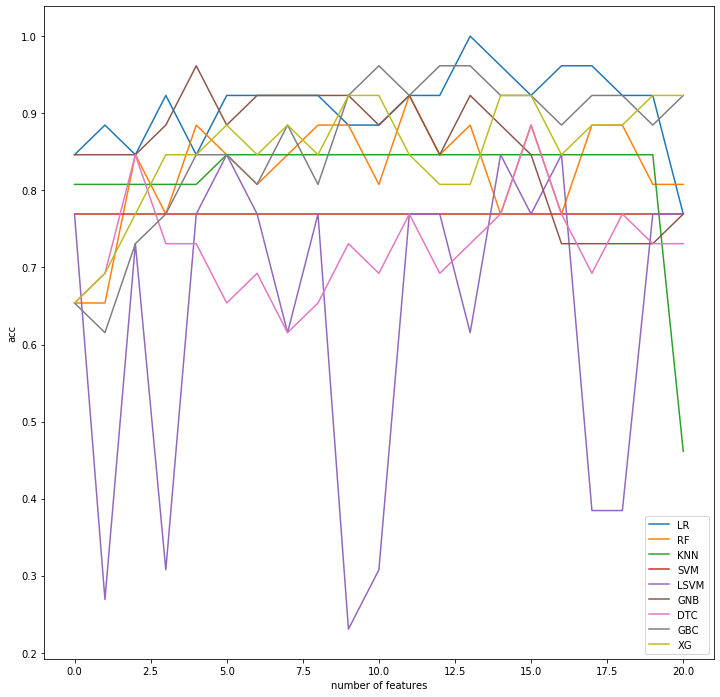

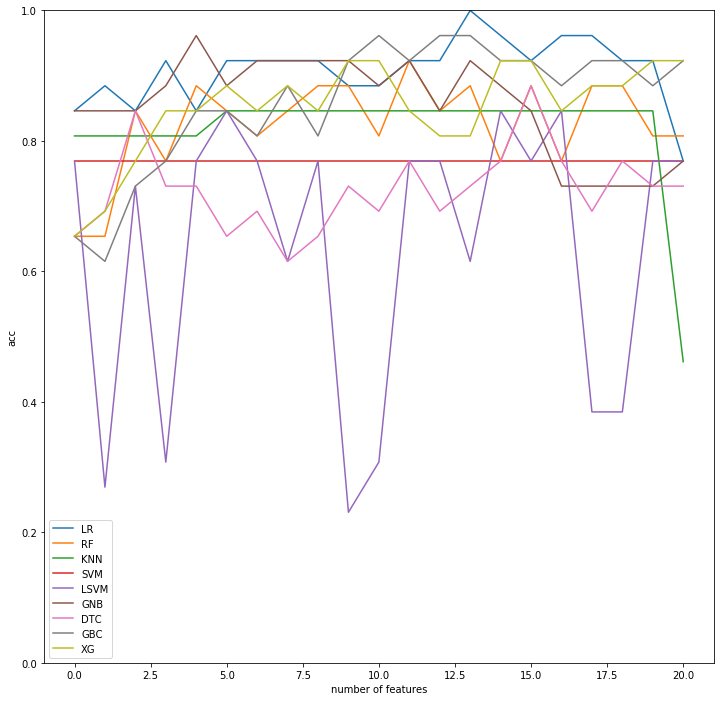

In [41]:

plot_tda_model_acc(model_list,acc_list)

In [13]:
len(selected_features)

50

In [67]:
distmat = np.arccos(abs(np.corrcoef(data_scaled.T)))

In [68]:
mds_feature = MDS(dissimilarity='precomputed').fit_transform(distmat)

In [69]:
cluster_label = pd.Series(np.zeros(len(data.columns)),index=data.columns)
for k,v in clusters.items():
    cluster_label[v] = k
cluster_label /= cluster_label.max()

In [70]:
selected_label = pd.Series(np.zeros(len(data.columns)),index=data.columns)
for i,f in enumerate(selected_features[:30]):
    selected_label[f] = 1
selected_label = 1-selected_label

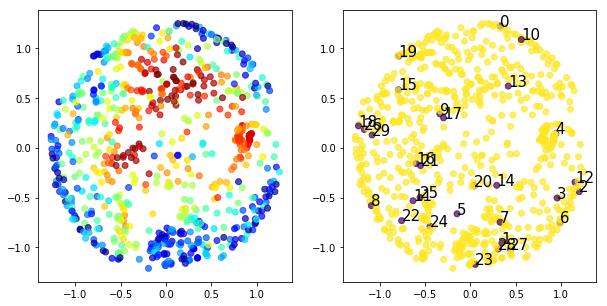

In [71]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].scatter(mds_feature[:,0],mds_feature[:,1],c=cluster_label,alpha=0.7,cmap=plt.cm.jet)
axes[1].scatter(mds_feature[:,0],mds_feature[:,1],c=selected_label,alpha=0.7)
for i,f in enumerate(selected_features[:30]):
    r = np.where(data.columns==f)[0]
    axes[1].text(mds_feature[r,0],mds_feature[r,1],i,fontsize=15)